<a href="https://colab.research.google.com/github/Gus-1003/Projeto_PalmaS/blob/main/Upgrade/Palma_Fase_1_Pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FASE_1 - Coleta e Extração de dados:

## Importando Bibliotecas:

In [1]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.cluster import KMeans

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


## Lendo Imagem:

In [ ]:
file = '/content/drive/MyDrive/Colab Notebooks/Bolsa/P3/P3.png'

im = cv.imread(file)

## Análise da Imagem Trabalhada:

### Visualizando imagem original:

In [ ]:
#cv2_imshow(im)

### Estudo das dimenssões:

In [ ]:
# Instrução para descobrir o tamanho da dimensão da imagem (Linhas x Colunas)
print('Dim:' + str(im.shape))

Dim:(179, 225, 3)


## Pré-Processamento:

### Clonando Imagem (Futura Comparação):



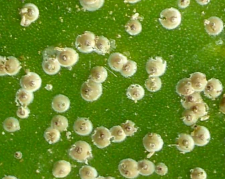

In [ ]:
compara = im.copy()
cv2_imshow(im)

### Split dos canais da imagem:

In [ ]:
im_split_channels = cv.split(im)

(B, G, R) = cv.split(im)
#cv2_imshow(cv.hconcat([R, G, B]))

In [ ]:
Azul = B # Melhor canal de cor para o processamento
#cv2_imshow(Azul)

### Histograma:

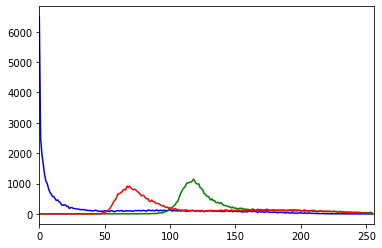

In [ ]:
# numero de bins do histograma
hist_size = 256

# faixa de valores de cada canal
hist_range = (0, 256) #0-255 (8 bits)
accumulate = False

color = ('b','g','r') #h, s, v

for i,col in enumerate(color):

    histr = cv.calcHist(im_split_channels,[i],None, [hist_size], hist_range, accumulate=accumulate)

    plt.plot(histr, color = col)

    plt.xlim([0,256])

    
plt.show()

### Threshold:

Limiarização - Usando a técnica de Otsu

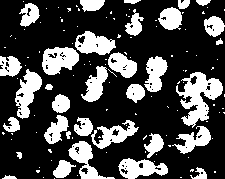

In [ ]:
ret, thresh = cv.threshold(Azul, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
cv2_imshow(thresh)

### Buscando Contornos:

In [ ]:
#contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

### Retirando dados dos contornos:

In [ ]:
rows, columns = thresh.shape
areaImagem = rows*columns

print('Dimensões da imagem:' + str(thresh.shape))
print("Rows = ",rows)
print("Columns = ", columns)

Dimensões da imagem:(179, 225)
Rows =  179
Columns =  225


In [ ]:
areaOcupada = 0

for qtd in range(len(contours)):
  atual = cv.contourArea(contours[qtd])
  areaOcupada = areaOcupada + atual

print("areaImagem = ", areaImagem)
print ('Foram encontrados ' + str(len(contours)) + ' objetos com seus contornos')
print('Area total ocupada: ' + str(areaOcupada))
print('Relação infestação/área total: ' + str((areaOcupada/(rows*columns))*100) + ' %')

cv.drawContours(im, contours, -1, (0,242,255), 2); #unico contorno 0
#cv2_imshow(cv.hconcat([compara, im]))

areaImagem =  40275
Foram encontrados 125 objetos com seus contornos
Area total ocupada: 10373.0
Relação infestação/área total: 25.755431409062695 %


### Laço: contours

In [ ]:
def extract_image(thresh, cnt):
  # np.zeros: Cria uma matriz com determinadas dimensões
  im_blank = np.zeros(im.shape, np.uint8) 

  cv.drawContours(im_blank, [cnt], -1, 255, -1)

  mask = im_blank == 255

  im_filter = im[mask]

  return im_filter

In [ ]:
areas = []
perimeters = []
centroids_x = []
centroids_y = []
aspect_ratio = [] #It is the ratio of width to height of bounding rect of the object.
extent = [] #Extent is the ratio of contour area to bounding rectangle area.
solidity = [] #Solidity is the ratio of contour area to its convex hull area.
equivalent_diameter = [] #Equivalent Diameter is the diameter of the circle whose area is same as the contour area.
r_mean = []
r_min = []
r_max = []
r_std = []
g_mean = []
g_min = []
g_max = []
g_std = []
b_mean = []
b_min = []
b_max = []
b_std = []
width = []
height = []
angle = []
radius = []


im_split_channels = cv.split(im)
album = [] 

for c in contours:
    M = cv.moments(c)
    
    areas.append(M['m00'])
    perimeters.append(cv.arcLength(c,True)) #if not convex, False
    
    x,y,w,h = cv.boundingRect(c)
    aspect_ratio.append(float(w)/h)
    width.append(w)
    height.append(h)
    rect = cv.minAreaRect(c)
    circle = cv.minEnclosingCircle(c)
    angle.append(rect[2])
    radius.append(circle[1])
    
    rect_area = w*h
    if rect_area > 0:
        extent.append(M['m00']/rect_area)
    else: 
        extent.append(0)
    
    hull = cv.convexHull(c)
    hull_area = cv.contourArea(hull)
    if hull_area > 0:
        solidity.append(M['m00']/hull_area)
    else:
        solidity.append(0)
    
    equivalent_diameter = np.sqrt(4*M['m00']/np.pi)
    
    if M['m00'] != 0:
        centroids_x.append(M['m10']/M['m00'])
        centroids_y.append(M['m01']/M['m00'])
    else:
        centroids_x.append(0)
        centroids_y.append(0)
        
    r = extract_image(im_split_channels[2], c)
    g = extract_image(im_split_channels[1], c)
    b = extract_image(im_split_channels[0], c)
    
    r_mean.append(np.mean(r))
    r_max.append(np.max(r))
    r_min.append(np.min(r))
    r_std.append(np.std(r))
    g_mean.append(np.mean(g))
    g_max.append(np.max(g))
    g_min.append(np.min(g))
    g_std.append(np.std(g))
    b_mean.append(np.mean(b))
    b_max.append(np.max(b))
    b_min.append(np.min(b))
    b_std.append(np.std(b))


### Agrupamentos de Features:

In [ ]:
#features = [areas, perimeters, aspect_ratio, extent, solidity, equivalent_diameter]

#interest_area_contours = sum(areas)/total_area
#print(interest_area_contours)

#d = {'area': areas, 'perimiter': perimeters}
#d = {'centroid_x': centroids_x, 'centroid_y': centroids_y, 'area': areas, 'perimiter': perimeters}
features_1 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter,
            'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
            'width': width, 'height': height, 'angle': angle, 'radius': radius
}

features_2 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter
}

features_3 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std
}

features_4 = {'r_mean': r_mean, 'g_mean': g_mean, 'b_mean': b_mean}

features_5 = {'r_mean': r_mean, 'g_mean': g_mean, 'b_mean': b_mean,
             'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
             'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter
}

features_6 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter 
}

features_7 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'solidity': solidity 
}

features_8 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'equivalent_diameter': equivalent_diameter, 'perimiter': perimeters
}

features_9 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

features_10 = {'r_max': r_max, 'g_max': g_max, 'b_max': b_max,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

features_11 = {'r_max': r_max, 'g_max': g_max, 'b_max': b_max,
               'r_min': r_min, 'g_min': g_min, 'b_min': b_min,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

## Processamento dos Dados:

In [ ]:
# df = pd.DataFrame(features_1)     # 125 Objetos - 101(instar 1 e 2)/ 16(instar 3 e Aglomerados menores)/ 8(instar 3 e Aglomerados maiores)

# df = pd.DataFrame(features_2)     # 125 Objetos - 102(instar 1 e 2)/ 8(instar 3 e Aglomerados maiores)/ 15(instar 3 e Aglomerados menores)

df = pd.DataFrame(features_3)     # 125 Objetos - 97(instar  1 e 2)/ 21(Grandes Aglomerados de Instar 3)/ 7(Aglomerados menores de Instar 3) - Uso Padrão

# df = pd.DataFrame(features_4)     # 125 Objetos - 7(instar 2/instar 3 menores)/ 100(instar 1)/ 18(instar 3 maiores e aglomerados)

# df = pd.DataFrame(features_5)     # 125 Objetos - 102(instar 1 e 2)/ 8((Aglomerados maiores de instar 3)/ 15(instar 3  e Aglomerados menores)

# df = pd.DataFrame(features_6)     # 125 Objetos - 97(instar 1)/ 21(instar 3 e Aglomerados)/ 7(instar 2 e Aglomerados menores de instar 3)

# df = pd.DataFrame(features_7)     # 125 Objetos - 97(instar 1)/ 21(instar 3 e Aglomerados)/ 7(instar 2 e Aglomerados menores de instar 3)

# df = pd.DataFrame(features_8)     # 125 Objetos - 97(instar 1)/ 22(instar 3 e Aglomerados)/ 6(instar 2 e 3)

# df = pd.DataFrame(features_9)     # 125 Objetos - 97(instar 1)/ 21(instar 3 e Aglomerados)/ 7(instar 2 e 3)

# df = pd.DataFrame(features_10)    # 125 Objetos - 99(instar 1)/ 6(instar 2, 3 e um pequeno aglomerado de instar 3)/ 20(instar 3 e Aglomerados)

# df = pd.DataFrame(features_11)    # 125 Objetos - 20(instar 3 e grandes Aglomerados)/ 99(instar 1)/ 6(instar 2, 3 e um pequeno aglomerado de instar 3)

Observação: Em quase todos os testes foram identificados em torno de 100 objetos do tipo instar 1 (Muitas vezes mesclados com instar 2).

In [ ]:
# df

In [ ]:
df.describe()

,r_mean,r_max,r_min,r_std,g_mean,g_max,g_min,g_std,b_mean,b_max,b_min,b_std
count,125.000000,125.000000,125.0,125.000000,125.000000,125.000000,125.0,125.000000,125.000000,125.000000,125.0,125.000000
mean,14.024203,-10.528000,0.0,15.256394,14.024203,-10.528000,0.0,15.256394,14.024203,-10.528000,0.0,15.256394
std,27.995383,22.744576,0.0,28.881345,27.995383,22.744576,0.0,28.881345,27.995383,22.744576,0.0,28.881345
min,0.000000,-127.000000,0.0,0.000000,0.000000,-127.000000,0.0,0.000000,0.000000,-127.000000,0.0,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
max,87.245774,0.000000,0.0,81.942723,87.245774,0.000000,0.0,81.942723,87.245774,0.000000,0.0,81.942723


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   r_mean  125 non-null    float64
 1   r_max   125 non-null    int8   
 2   r_min   125 non-null    int8   
 3   r_std   125 non-null    float64
 4   g_mean  125 non-null    float64
 5   g_max   125 non-null    int8   
 6   g_min   125 non-null    int8   
 7   g_std   125 non-null    float64
 8   b_mean  125 non-null    float64
 9   b_max   125 non-null    int8   
 10  b_min   125 non-null    int8   
 11  b_std   125 non-null    float64
dtypes: float64(6), int8(6)
memory usage: 6.7 KB


In [6]:
# Taking input as string
nome_image = input("What color is rose?: ")
print(nome_image)

What color is rose?: base4
base4


In [ ]:
PF_1_csv = df.to_csv('/content/drive/MyDrive/Pesquisa_Cochonilha/CSV´S/{}.csv'.format(nome_image))

## Kmeans:

In [ ]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, algorithm='full') #auto, full, elkan
kmeans.fit(df) # Metodo fit

KMeans(algorithm='full', n_clusters=3)

In [ ]:
conts = [[],[],[],[]] #contour list

for cont, cnt in enumerate(contours):
    class_ = kmeans.predict([df.iloc[cont]])[0]
    conts[class_].append(cnt)
    
if n_clusters == 3:
    im = cv.drawContours(im, conts[0], -1, (200, 120, 0), thickness=2) # Azul
    im = cv.drawContours(im, conts[1], -1, (20, 150, 232), thickness=2) # Laranja
    im = cv.drawContours(im, conts[2], -1, (82, 184, 10), thickness=2) # Verde
elif n_clusters == 2:
    im = cv.drawContours(im, conts[0], -1, (20, 150, 232), thickness=2)
    im = cv.drawContours(im, conts[1], -1, (82, 184, 10), thickness=2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/pytho

class 0: 97 individuals
class 1: 21 individuals
class 2: 7 individuals
class 3: 0 individuals


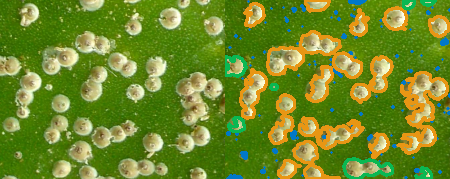

In [ ]:
print('class 0: ' + str(len(conts[0])) + ' individuals')
print('class 1: ' + str(len(conts[1])) + ' individuals')
print('class 2: ' + str(len(conts[2])) + ' individuals')
print('class 3: ' + str(len(conts[3])) + ' individuals')

cv2_imshow(cv.hconcat([compara, im]))